# Transfer Learning on Oyster and green oyster mushroom

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from keras.applications.mobilenet import MobileNet, decode_predictions, preprocess_input
from keras import preprocessing
from tensorflow.keras.preprocessing import image
import keras.backend as K
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,InputLayer,Dropout

### Pretrained Model: MobileNet from Keras (https://keras.io/api/applications/)

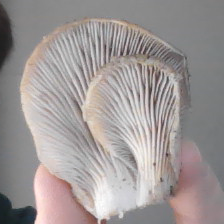

In [3]:
img = image.load_img('oyster.png')
img

In [4]:
type(img)

PIL.PngImagePlugin.PngImageFile

##### Expand dimensions

In [5]:
x = np.array(img)
x.shape 

(224, 224, 3)

In [6]:
X = np.array([x]) # Hint: Model expects a batch 
X.shape           # i.e. a "batch" of one image, with the rest of expected shape...reminiscient of the data types expected by sklearn models

(1, 224, 224, 3)

#### Prepare data based on specifications of pre-trained model

In [7]:
X = preprocess_input(X) # essentially: scale vals between 0 and 255 to -1 < x < 1

#### Load MobileNet model

In [8]:
model = MobileNet()  # download (on `ImageNet` pretrained) model 

#### Test model

In [9]:
pred = model.predict(X)
pred.shape

1/1 [==============================] - 1s 983ms/step


(1, 1000)

In [10]:
pred[0,:10] # MobileNet predicts whether an image belongs to one of 1k classes (i.e. prob of belonging to one of these classes)

array([1.1307245e-05, 1.3474532e-05, 4.2134889e-07, 2.3507757e-05,
       4.8135134e-06, 8.3248982e-05, 1.1059098e-05, 4.8850251e-07,
       1.1946134e-05, 5.0968661e-06], dtype=float32)

In [11]:
decode_predictions(pred) # make these preds "human-readable"

[[('n13052670', 'hen-of-the-woods', 0.73255336),
  ('n01924916', 'flatworm', 0.07119695),
  ('n07734744', 'mushroom', 0.05979374),
  ('n13044778', 'earthstar', 0.035448585),
  ('n01968897', 'chambered_nautilus', 0.010235114)]]

#### Check what is really in the image

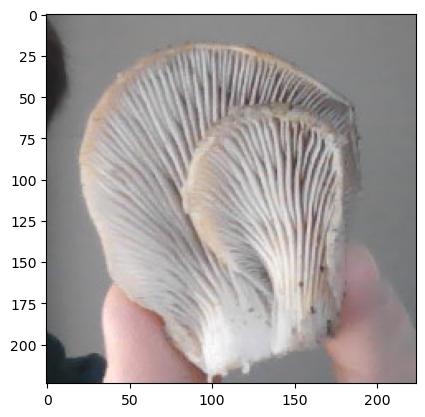

In [12]:
plt.imshow(img);

In [13]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

# Transfer Learning for Neural Networks

In [14]:
# folder names containing images of the things you want to classify
classes = ['oyster_all','green_oyster']
# plug in the path to your data folder
base_path = './images/folder/'

In [15]:
# define the preprocessing function that should be applied to all images
data_gen = preprocessing.image.ImageDataGenerator(   # loads data in batches from disk
    preprocessing_function=preprocess_input,
    # fill_mode='nearest',
    rotation_range=20,                               # rotate image by a random degree between -20 and 20
    # width_shift_range=0.2,                         # shift image horizontally 
    # height_shift_range=0.2,                        # shift image vertically 
    # horizontal_flip=True,                          # randomly flip image horizontally
    zoom_range=0.5,                                  # apply zoom transformation using zoom factor between 0.5 and 1.5
    # shear_range=0.2                                # shear rotates pics, but makes them be in trapezoids (as opposed to squares)
    validation_split=0.2
)

In [16]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(      # points to dir where data lives
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=32,
        target_size=(224, 224),
    subset='training'
)

Found 1485 images belonging to 2 classes.


In [17]:
val_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=32,
        target_size=(224, 224),
    subset='validation'
)

Found 371 images belonging to 2 classes.


In [18]:
train_data_gen.class_indices

{'oyster_all': 0, 'green_oyster': 1}

In [19]:
classes

['oyster_all', 'green_oyster']

## Create CNN Model as Base Model

### 1. Select the convolutional base 

#### Using MobileNet pretrained network for transfer learning

In [20]:
K.clear_session()
base_model = MobileNet(
    weights='imagenet',
    include_top=False,                          # keep convolutional layers only
    input_shape=(224, 224, 3)
)

In [21]:
base_model.summary()                            # as expected...see above

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### 2. Freeze the weights

In [22]:
base_model.trainable = False  # we don't want to train the base model, since this would destroy filters

## Build your "individualized" architecture for "top-layers"

### 3. Add your own dense layers on top

In [23]:
len(classes)

2

In [24]:
model = keras.Sequential()
model.add(base_model)
model.add(Flatten())  
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax')) # TODO; Final layer with a length of 2, and softmax activation

In [25]:
model.summary()                 # Note "non-trainable" params...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 100)               5017700   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 8,246,766
Trainable params: 5,017,902
Non-trainable params: 3,228,864
______________________________________

### 4. Compile and train

In [26]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy, #TODO: why not binary x-entropy?
              metrics='accuracy')

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.05,     # the minimum expected change in the metric used in order to be seen as an improvement
    patience=3,         # number of epochs with no improvement needed for the model to stop
    restore_best_weights=True,
    mode='min'
    )

#### Hint: Make sure, you have enough memory (RAM) on your computer. Instead, you could use Google Colab or Kaggle to run the whole script + data on the GPU ("Laufzeittyp ändern -> Hardwarebeschleuniger GPU")

In [27]:
history = model.fit(train_data_gen,
          verbose=2, 
          callbacks=[callback],
          epochs=20,
          validation_data=val_data_gen
          )

Epoch 1/20
47/47 - 41s - loss: 1.3403 - accuracy: 0.9125 - val_loss: 0.0845 - val_accuracy: 0.9811 - 41s/epoch - 875ms/step
Epoch 2/20
47/47 - 37s - loss: 0.0274 - accuracy: 0.9926 - val_loss: 0.0351 - val_accuracy: 0.9892 - 37s/epoch - 787ms/step
Epoch 3/20
47/47 - 38s - loss: 0.0159 - accuracy: 0.9966 - val_loss: 0.0319 - val_accuracy: 0.9892 - 38s/epoch - 818ms/step
Epoch 4/20
47/47 - 37s - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0251 - val_accuracy: 0.9946 - 37s/epoch - 781ms/step
Epoch 5/20
47/47 - 36s - loss: 0.0105 - accuracy: 0.9939 - val_loss: 0.0120 - val_accuracy: 0.9973 - 36s/epoch - 774ms/step
Epoch 6/20
47/47 - 36s - loss: 0.0034 - accuracy: 0.9993 - val_loss: 3.4638e-04 - val_accuracy: 1.0000 - 36s/epoch - 772ms/step


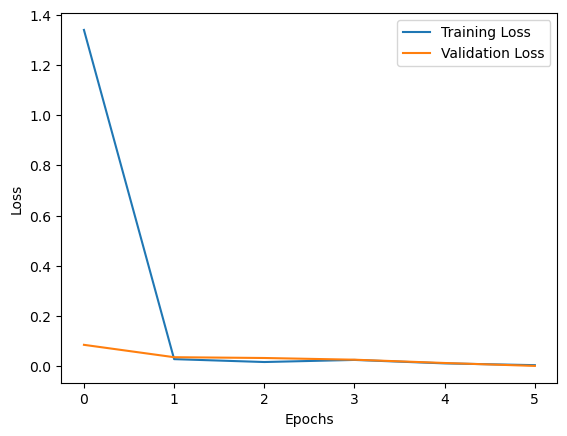

In [28]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### (5. Use it to predict)

In [29]:
img = image.load_img('object.png',target_size=(224,224))

FileNotFoundError: [Errno 2] No such file or directory: 'object.png'

In [ ]:
plt.imshow(img);

In [ ]:
img.size

In [ ]:
x = np.array(img)

In [ ]:
X = np.array([x]) 
X.shape 

In [ ]:
X_preprocess = preprocess_input(X)

In [ ]:
pred = model.predict(X_preprocess)
pred

In [ ]:
plt.bar(x = classes, height = pred[0]);

### (6. Save your model for later)

In [ ]:
# model.save('models/wallet_phone.h5')